In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_logistic import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
np.random.seed(1)
random.seed(1)

In [3]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/4/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2/4+lambd)
    mu = lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [4]:
algo_func_pair = {
    "L-SVRG": L_SVRG,
    "RR": RR_SGD,
    "RR-SVRG": RR_SVRG,
    "SVRG": SVRG,
    "RR-SAGA": SAGA_RR,
    "SAGA": SAGA,
    "RR-VR.9": RR_VR,
    "RR-VR.5": RR_VR,
    "RR-VR.95": RR_VR,
    "RR-VR.8": RR_VR       
}

In [5]:
names = {
    "L-SVRG": "L_SVRG",
    "RR": "RR_SGD",
    "RR-SVRG": "Rand-Reshuffle",
    "SVRG": "SVRG",
    "RR-SAGA": "RR-SAGA",
    "SAGA": "SAGA",
    "RR-VR.9": "RR_VR",
    "RR-VR.5": "RR_VR",
    "RR-VR.95": "RR_VR",
    "RR-VR.8": "RR_VR"
}

In [6]:
algo_color_pair = {
    "L-SVRG": 'green',
    "RR": 'brown',
    "RR-SVRG": 'red',
    "SVRG": 'hotpink',
    "RR-SAGA": 'teal',
    "SAGA": 'purple',
    "RR-VR.9": 'navy',
    "RR-VR.5": 'limegreen',
    "RR-VR.95": 'grey',
    "RR-VR.8": 'pink'
}

In [7]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    return A, y, n, d, lambd, L, mu, L_max, L_i_list

#### Experiment #2
Comparison of SAGA, SAGA-RR, RR-SVRG, L-SVRG, RR-VR0.5

Dataset: bodyfat, a1a

Algorithms: SAGA, SAGA_RR, RR_SVRG, L_SVRG, SVRG, RR-VR.5

In [8]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR-VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR-VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR-VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [9]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "bodyfat"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [10]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 252, d = 14, L = 0.25249, L_max = 0.25397, mu = 0.00397, kappa = 64.00000


In [11]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12)

KeyboardInterrupt: 

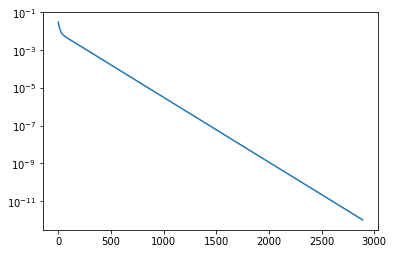

In [18]:
plt.semilogy(grad_norms)
plt.show()

In [19]:
stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [20]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[15])
            if (best_error > alg_grad[15]):
                    best_error = alg_grad[15].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)

SAGA
2.220022314014288e-07
3.9606082513240892 SAGA
3.338246892796466e-07
2.3991097013433636e-07
2.0097833582087176e-07
0.792121650264818 SAGA
1.7614239760611512e-05
RR-SAGA
3.749052678213239e-09
3.9606082513240892 RR-SAGA
2.444414002245905e-08
1.4589940164369046e-07
1.8368879561086166e-06
4.931428710087066e-05
RR-SVRG
4.3814110905516056e-17
3.9606082513240892 RR-SVRG
8.900320962976782e-16
1.9381486507194808e-11
5.641975128541751e-08
2.21803110092498e-05
L-SVRG
2.6831320508271706e-17
3.9606082513240892 L-SVRG
3.1027002720270196e-15
1.8528418054468287e-11
5.616393851289962e-08
2.215201679835024e-05
RR-VR.5
6.520698694174073e-17
3.9606082513240892 RR-VR.5
1.9043369423425093e-15
1.93748893925685e-11
5.644856811733304e-08
2.218077577444853e-05
SVRG
2.3463898528401595e-17
3.9606082513240892 SVRG
9.112891788792233e-16
1.947660058032538e-11
5.648931330104829e-08
2.2191240936482985e-05


In [21]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


In [12]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    markers_algo = {'SAGA':'v', 'RR-SAGA':'^', 'RR-SVRG':'*', 'L-SVRG':'s','RR-VR.5':'>','SVRG':'d'}
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'RR-VR.5'):
            continue        
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = names[algo], marker=markers_algo[algo], color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

In [13]:
def plot_results_grad(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'RR-VR.5'):
            continue
        plt.semilogy(results[algo]['grad_comps'][0], results[algo]['grad_norms'][0], label = names[algo], marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||\nabla f(x_k)||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

In [15]:
import pickle

In [21]:
file = open('logistic_saga_svrg_rr_a1a_normalized_lambd_1_n.pickle','r')
results = pickle.load(file)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [14]:
plot_results_grad(results, xlim = 20, ylim = 1e-19,save='True')

NameError: name 'results' is not defined

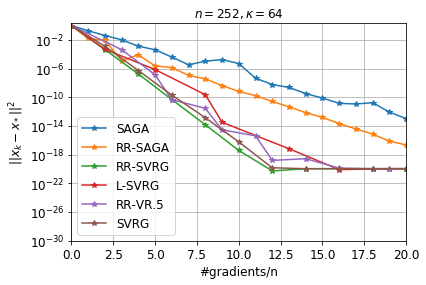

In [25]:
plot_results(results, xlim = 20, ylim = 1e-30)

In [26]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_bodyfat_normalized_lambd_1_n


In [15]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_bodyfat_normalized_lambd_1_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


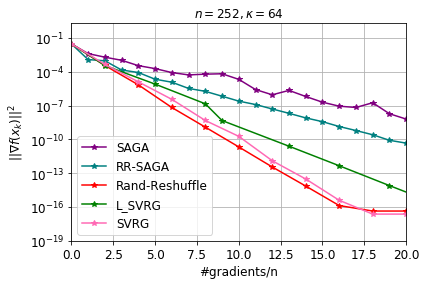

In [24]:
plot_results_grad(in_pickle['results'], xlim = 20, ylim = 1e-19, filename=name+'grad_neurips.pdf', save = True)

In [27]:
# plot_results_grad(results, xlim = 20, ylim = 1e-19, filename=name+'grad.pdf', save = True)

In [28]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 2nd plot

In [25]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "bodyfat"
NORMALIZE = True
STR_LAMBDA = '10_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [26]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 252, d = 14, L = 0.28820, L_max = 0.28968, mu = 0.03968, kappa = 7.30000


In [27]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12)

In [32]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []    
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[15])
            if (best_error > alg_grad[15]):
                    best_error = alg_grad[15].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)        

SAGA
4.703529263005434e-05
3.9606082513240892 SAGA
1.0904768156982725e-05
1.9803041256620446 SAGA
3.5815219307712757e-06
1.3202027504413631 SAGA
4.110470620432281e-06
4.077392650022197e-06
RR-SAGA
4.572098569144994e-07
3.9606082513240892 RR-SAGA
3.410612599164116e-09
1.9803041256620446 RR-SAGA
6.241876529805855e-09
1.2536151360144679e-08
3.7600757851495e-08
RR-SVRG
2.444052391651729e-17
3.9606082513240892 RR-SVRG
1.622685226974697e-17
1.9803041256620446 RR-SVRG
6.630638695609561e-17
1.3026895518794543e-16
2.7784562886930226e-16
L-SVRG
2.810573257811611e-17
3.9606082513240892 L-SVRG
4.043245606657567e-17
7.25323960516414e-17
1.3838973300387967e-16
8.554842949272357e-17
RR-VR.5
2.788996239899017e-16
3.9606082513240892 RR-VR.5
4.083975299257731e-17
1.9803041256620446 RR-VR.5
2.9400876276408453e-17
1.3202027504413631 RR-VR.5
8.117597681620805e-17
1.9268905138986157e-16
SVRG
3.427999697535028e-17
3.9606082513240892 SVRG
1.4846841437362876e-17
1.9803041256620446 SVRG
8.371276558483866e-17
7.

In [33]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


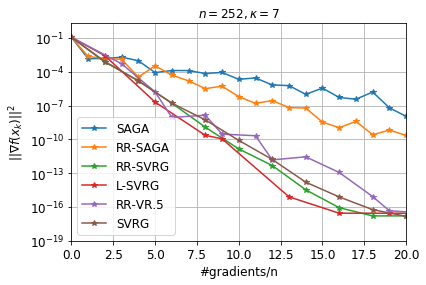

In [34]:
plot_results_grad(results, xlim=20, ylim=1e-19)

In [35]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_bodyfat_normalized_lambd_10_n


In [28]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_bodyfat_normalized_lambd_10_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


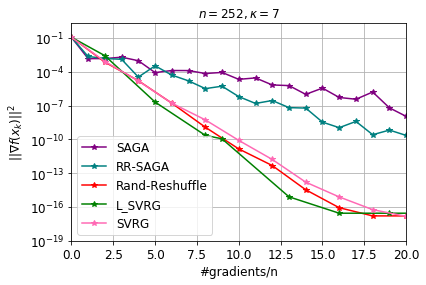

In [30]:
plot_results_grad(in_pickle['results'], xlim=20, ylim=1e-19, filename=name+'grad_neurips.pdf', save=True)  

In [37]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 3rd plot

In [31]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "a1a"
NORMALIZE = True
STR_LAMBDA = '1_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [32]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 1605, d = 119, L = 0.11358, L_max = 0.25062, mu = 0.00062, kappa = 402.25000


In [40]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12, max_iters_num=1000)

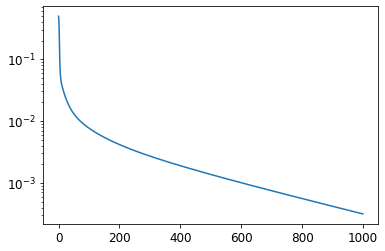

In [47]:
plt.semilogy(grad_norms)
plt.show()

In [48]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[20])
            if (best_error > alg_grad[20]):
                    best_error = alg_grad[20].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)

SAGA
7.303995830231308e-05
3.4698035207912588 SAGA
2.864889389316456e-06
1.7349017603956294 SAGA
1.2471233451163755e-06
1.1566011735970863 SAGA
1.4312373835634335e-07
0.6939607041582518 SAGA
4.4599263882144085e-06
RR-SAGA
1.1899985967002632e-05
3.4698035207912588 RR-SAGA
9.255667940481066e-09
1.7349017603956294 RR-SAGA
6.6321486221634985e-09
1.1566011735970863 RR-SAGA
1.784560518242439e-07
1.079960285418433e-05
RR-SVRG
2.6562086026068483e-07
3.4698035207912588 RR-SVRG
1.8038079389669766e-10
1.7349017603956294 RR-SVRG
4.297123744792499e-13
1.1566011735970863 RR-SVRG
4.207711240661445e-09
4.493768545039292e-06
L-SVRG
7.928500971712031e-05
3.4698035207912588 L-SVRG
8.485058703097519e-07
1.7349017603956294 L-SVRG
8.283093373025646e-09
1.1566011735970863 L-SVRG
1.6622265649129165e-08
4.696990625227289e-06
RR-VR.5
0.00013320869051762797
3.4698035207912588 RR-VR.5
5.998829389201532e-08
1.7349017603956294 RR-VR.5
2.6197969327030687e-08
1.1566011735970863 RR-VR.5
4.2556839875823485e-09
0.693960

In [49]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


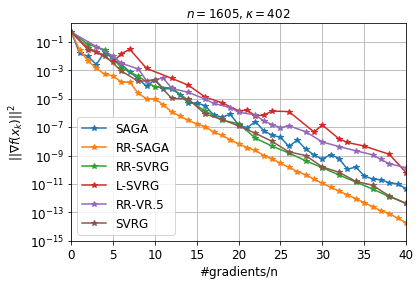

In [55]:
plot_results_grad(results, xlim=40, ylim=1e-15)

In [56]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_a1a_normalized_lambd_1_n


In [33]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_a1a_normalized_lambd_1_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


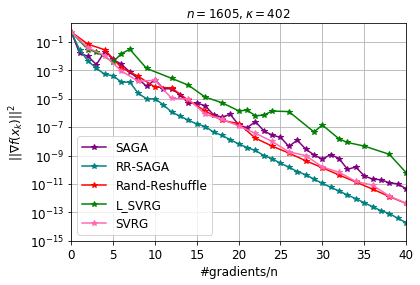

In [35]:
plot_results_grad(in_pickle['results'], xlim=40, ylim=1e-15, filename=name+'grad_neurips.pdf', save=True) 

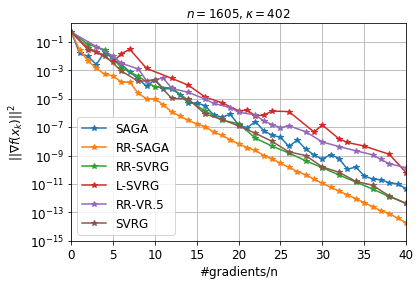

In [57]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

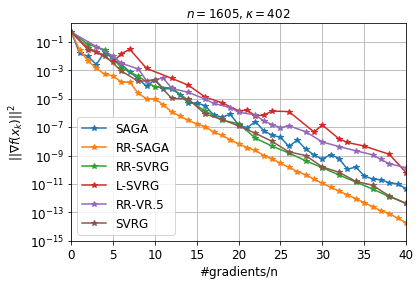

In [58]:
# plot_results_grad(results, xlim=40, ylim=1e-15, filename=name+'grad.pdf', save=True) 